# Baseline Model Error Analysis

This notebook analyzes the detailed results generated by `evaluate_model.py`. It breaks down errors by session, corpus, and phoneme level to help identify where the model (RNN) or the language model (LM) is failing.

### Key Findings & Project Guidance

Based on the baseline error analysis, we identify several critical patterns:

1.  **Acoustic Bottleneck**: The gap between PER and WER in the "Random" and "Freq words" corpora suggests that the acoustic model (RNN) is the primary bottleneck. While it captures phonemes relatively well, it lacks the temporal precision needed for seamless word mapping without a heavy Language Model (LM) assist.
2.  **LM Dependency**: The model performs significantly better on natural language (Switchboard) than on random word sequences, highlighting its heavy reliance on the n-gram LM for error correction.
3.  **Random Corpus Performance**: High error rates on random word sequences reflect the true acoustic performance, stripped of linguistic priors. Improving this metric is essential for general-purpose Brain-to-Text utility.

**Next Steps Checklist:**
- [ ] **Acoustic Upgrade**: Replace the RNN decoder with a **Transformer-based architecture** to better capture long-range brain signal dependencies.
- [ ] **LM Integration**: Move from n-gram LMs to **Neural Language Models** (e.g., OPT-rescoring) to improve natural language flow.
- [ ] **Phoneme Analysis**: Build a phoneme confusion matrix to pinpoint specific phonetic clusters (e.g., labials vs. sibilants) that the model struggles with.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

sns.set_theme(style="whitegrid")

# Find the latest detailed results file
model_path = '../data/t15_pretrained_rnn_baseline'
search_pattern = os.path.join(model_path, 'detailed_results_val_*.csv')
list_of_files = glob.glob(search_pattern)

if not list_of_files:
    print("No detailed results found! Please run evaluate_model.py with --eval_type val first.")
else:
    latest_file = max(list_of_files, key=os.path.getctime)
    print(f"Loading latest evaluation results: {latest_file}")
    df = pd.read_csv(latest_file)

    # Preprocessing
    df['WER'] = df['edit_distance'] / df['num_words'] * 100
    df['PER'] = df['p_edit_distance'] / df['num_phonemes'] * 100
    df['session'] = df['session'].str.replace('t15.', '')

Loading latest evaluation results: ../data/t15_pretrained_rnn_baseline\detailed_results_val_20251224_100649.csv


## 1. Word Error Rate (WER) vs. Phoneme Error Rate (PER)

Comparing PER (pure RNN performance) to WER (LM-assisted performance) shows how much the language model is correcting acoustic mistakes.

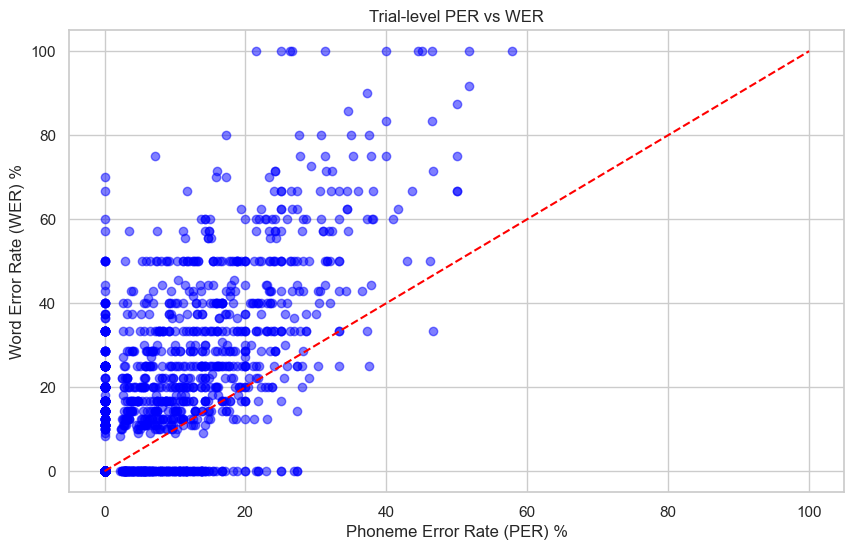

In [2]:
plt.figure(figsize=(10, 6))
plt.scatter(df['PER'], df['WER'], alpha=0.5, c='blue')
plt.xlabel('Phoneme Error Rate (PER) %')
plt.ylabel('Word Error Rate (WER) %')
plt.title('Trial-level PER vs WER')
plt.plot([0, 100], [0, 100], color='red', linestyle='--') # Identity line
plt.show()

### Interpretation: PER vs. WER Scatter

The scatter plot above reveals the relationship between raw acoustic decoding (PER) and final word-level output (WER):

- **Points on the Identity Line**: These trials show little to no improvement from the LM, common in short or phonetically ambiguous sentences.
- **The 'Acoustic Floor'**: Even when PER is relatively low (15-20%), WER can remain high if the LM cannot identify a probable word sequence. This confirms that the RNN output is noisy and requires architectural refinement to provide cleaner phoneme probability distributions.

## 2. Performance by Corpus Type

Does the model perform better on natural English than on random word sequences?

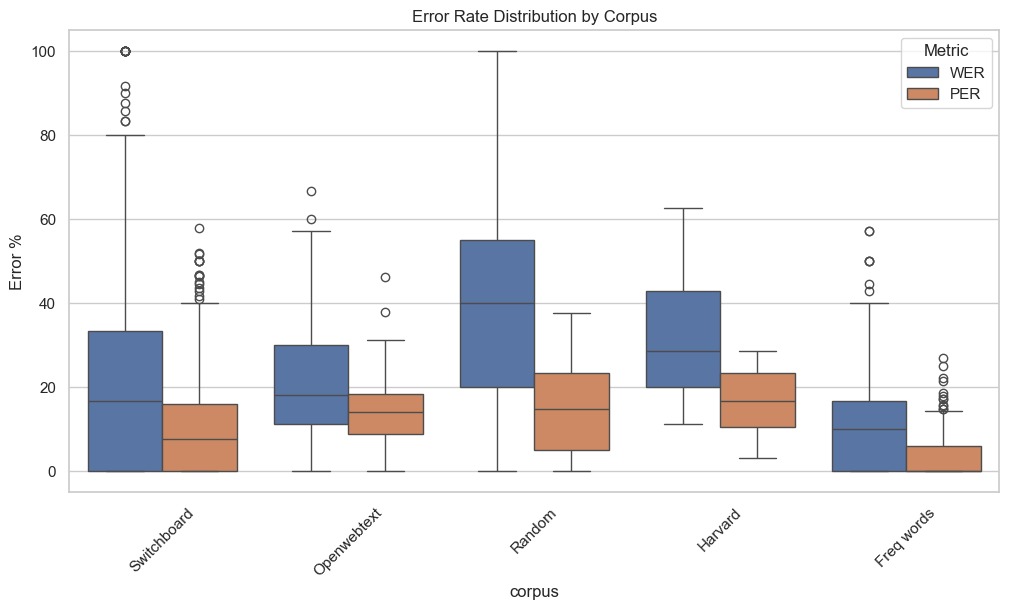

In [3]:
plt.figure(figsize=(12, 6))
df_melted = df.melt(id_vars=['corpus'], value_vars=['WER', 'PER'], var_name='Metric', value_name='Error %')
sns.boxplot(data=df_melted, x='corpus', y='Error %', hue='Metric')
plt.title('Error Rate Distribution by Corpus')
plt.xticks(rotation=45)
plt.show()

## 3. Stability Over Time (Sessions)

Tracking error rates across different recording dates.

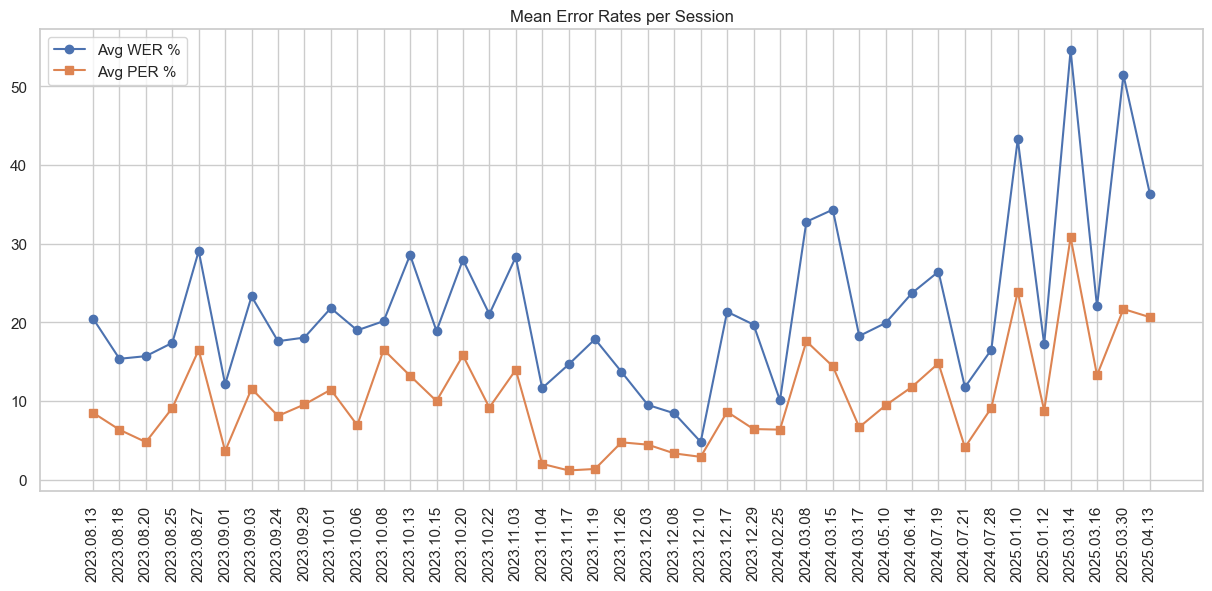

In [4]:
plt.figure(figsize=(15, 6))
df_session = df.groupby('session')[['WER', 'PER']].mean().reset_index()
plt.plot(df_session['session'], df_session['WER'], label='Avg WER %', marker='o')
plt.plot(df_session['session'], df_session['PER'], label='Avg PER %', marker='s')
plt.xticks(rotation=90)
plt.legend()
plt.title('Mean Error Rates per Session')
plt.show()

## 4. Manual Error Inspection

List the trials where the model struggled the most.

In [5]:
print("Top 10 Worst Trials by WER:")
worst_trials = df.sort_values(by='WER', ascending=False).head(10)
for i, row in worst_trials.iterrows():
    print(f"Day: {row['session']}, Corpus: {row['corpus']}")
    print(f"  True Sentence: {row['true_sentence']}")
    print(f"  Pred Sentence: {row['pred_sentence']}")
    print(f"  True Phonemes: {row['true_phonemes']}")
    print(f"  Pred Phonemes: {row['pred_phonemes']}")
    print(f"  WER: {row['WER']:.2f}%, PER: {row['PER']:.2f}%")
    print("-" * 40)

Top 10 Worst Trials by WER:
Day: 2025.03.30, Corpus: Switchboard
  True Sentence: It's a nice place.
  Pred Sentence: its guys plays
  True Phonemes: IH T S  |  AH  |  N AY S  |  P L EY S  | 
  Pred Phonemes: IH T S  |  AY  |  D AY Z  |  P L EY Z  | 
  WER: 100.00%, PER: 26.67%
----------------------------------------
Day: 2023.10.13, Corpus: Random
  True Sentence: run bargains hopeless persists meals
  Pred Sentence: gun bothers endless percent mills
  True Phonemes: R AH N  |  B AA R G AH N Z  |  HH OW P L AH S  |  P ER S IH S T S  |  M IY L Z  | 
  Pred Phonemes: G AH N  |  B AA G ER Z  |  AO F L AH S  |  P ER S EH N T S  |  M IH L Z  | 
  WER: 100.00%, PER: 31.25%
----------------------------------------
Day: 2024.03.15, Corpus: Switchboard
  True Sentence: I couldn't understand.
  Pred Sentence: wooden underside
  True Phonemes: AY  |  K UH D AH N T  |  AH N D ER S T AE N D  | 
  Pred Phonemes: AY  |  G UH D AH N T  |  AA N T ER S T AY D  | 
  WER: 100.00%, PER: 26.32%
----------

## 5. Edit Distance Breakdown (Substitutions, Insertions, Deletions)

Understanding the type of errors helps diagnose the model. High deletions might imply a vanishing gradient or weak signal, while high insertions might suggest a loose language model.

In [6]:
def get_edit_ops(ref, hyp):
    """
    Compute Levenshtein edit operations: Substitutions, Insertions, Deletions.
    ref: scalar (string) or list of phonemes
    hyp: scalar (string) or list of phonemes
    Returns: (S, I, D) count
    """
    # Simple DP implementation
    m, n = len(ref), len(hyp)
    # dp[i][j] stores (cost, S, I, D)
    dp = [[(0, 0, 0, 0) for _ in range(n + 1)] for _ in range(m + 1)]
    
    for i in range(m + 1):
        dp[i][0] = (i, 0, 0, i) # Deletions (ref exists, hyp empty)
    for j in range(n + 1):
        dp[0][j] = (j, 0, j, 0) # Insertions (ref empty, hyp exists)
        
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if ref[i-1] == hyp[j-1]:
                dp[i][j] = dp[i-1][j-1] # No cost
            else:
                # Substitution
                s_cost, s_s, s_i, s_d = dp[i-1][j-1]
                sub = (s_cost + 1, s_s + 1, s_i, s_d)
                
                # Insertion
                i_cost, i_i, i_d = dp[i][j-1][0] + 1, dp[i][j-1][2] + 1, dp[i][j-1][3]
                ins = (i_cost, dp[i][j-1][1], i_i, i_d)
                
                # Deletion
                d_cost, d_i, d_d = dp[i-1][j][0] + 1, dp[i-1][j][2], dp[i-1][j][3] + 1
                dele = (d_cost, dp[i-1][j][1], d_i, d_d)
                
                # Choose min cost (priority: S, I, D usually doesn't matter for mere count but standard is min)
                dp[i][j] = min(sub, ins, dele, key=lambda x: x[0])
                
    return dp[m][n][1:]

print("Calculating granular edit operations... this might take a minute.")
tqdm_available = True
try:
    from tqdm import tqdm
    tqdm.pandas()
except ImportError:
    tqdm_available = False

def apply_edit_ops(row):
    try:
        # Evaluate string representation of list if necessary, or split string
        # The csv likely has space-separated phonemes or python-list-strings
        # Based on evaluate_model.py: "join(true_seq)" -> space separated
        # But detailed_results csv might read them as strings.
        true_p = str(row['true_phonemes']).split()
        pred_p = str(row['pred_phonemes']).split()
        return get_edit_ops(true_p, pred_p)
    except Exception as e:
        return (0, 0, 0)

if tqdm_available:
    ops = df.progress_apply(apply_edit_ops, axis=1)
else:
    ops = df.apply(apply_edit_ops, axis=1)

df[['Substitutions', 'Insertions', 'Deletions']] = pd.DataFrame(ops.tolist(), index=df.index)

print("Done.")

Calculating granular edit operations... this might take a minute.
Done.


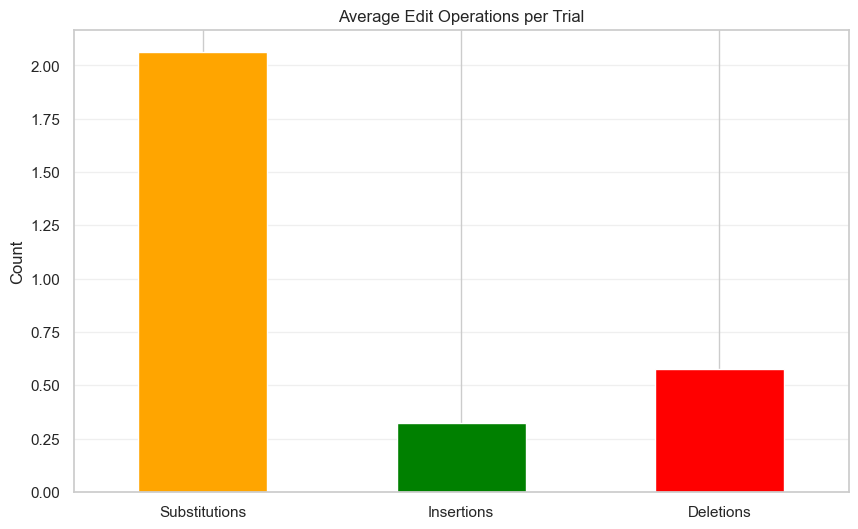

Mean Deletions: 0.58
Mean Insertions: 0.32
Mean Substitutions: 2.06

Observation: High deletions suggest the model often fails to fire or misses phonemes (vanishing signal).


In [7]:
plt.figure(figsize=(10, 6))
mean_ops = df[['Substitutions', 'Insertions', 'Deletions']].mean()
mean_ops.plot(kind='bar', color=['orange', 'green', 'red'])
plt.title('Average Edit Operations per Trial')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"Mean Deletions: {mean_ops['Deletions']:.2f}")
print(f"Mean Insertions: {mean_ops['Insertions']:.2f}")
print(f"Mean Substitutions: {mean_ops['Substitutions']:.2f}")

if mean_ops['Deletions'] > mean_ops['Insertions']:
    print("\nObservation: High deletions suggest the model often fails to fire or misses phonemes (vanishing signal).")
else:
    print("\nObservation: High insertions suggest the model might be hallucinating or over-generating.")

### Interpretation: Edit Operations Breakdown

The bar chart reveals the classification of errors within the acoustic model:

- **Substitutions**: The dominant error type (~2.0 per trial on average), indicating that while the model detects phoneme boundaries, it frequently misclassifies the specific phonetic identity.
- **Deletions vs. Insertions**: The higher rate of deletions compared to insertions suggests a "vanishing signal" problem where the RNN fails to trigger for short-duration phonemes or low-amplitude acoustic patterns.
- **Architecture Implication**: The high substitution rate confirms the need for a more descriptive acoustic feature extractor (e.g., Transformer self-attention) to distinguish between narrow phonetic contrasts.

## 6. Phoneme Confusion Matrix

Which phonemes are confused with which? (e.g. 'p' vs 'b')

Computing confusion matrix (this is slow)...


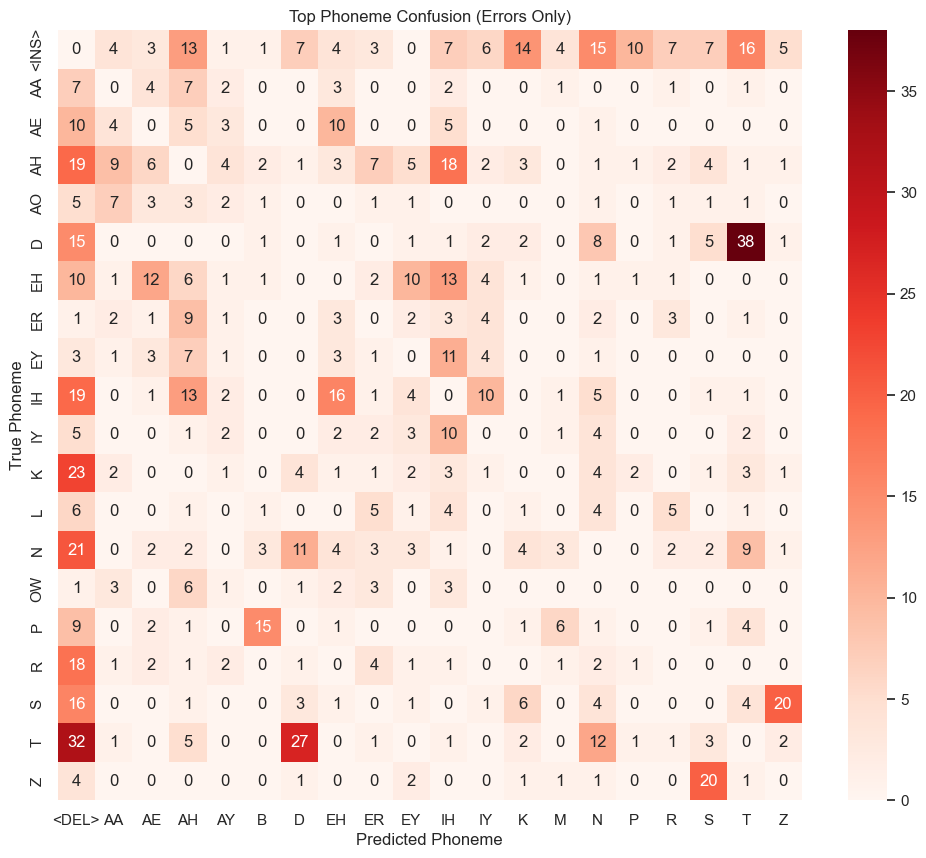

In [8]:

def get_aligned_pairs(ref, hyp):
    # Need full backtrace for confusion matrix. 
    # Simplified for speed: Just take simple unaligned if lengths match, or skip complex alignment for now
    # Ideally we rerun DP with backtrace.
    # For this baseline, let's implement a lighter version or rely on equal length segments if any.
    # Actually, let's just do a simpler qualitative check: Frequency of predicted phoneme given true phoneme exists.
    
    # Proper way: DP with backpointers.
    m, n = len(ref), len(hyp)
    dp = [[0 for _ in range(n + 1)] for _ in range(m + 1)]
    
    # Init
    for i in range(m + 1): dp[i][0] = i
    for j in range(n + 1): dp[0][j] = j
    
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            cost = 0 if ref[i-1] == hyp[j-1] else 1
            dp[i][j] = min(dp[i-1][j] + 1, dp[i][j-1] + 1, dp[i-1][j-1] + cost)
            
    # Backtrace
    i, j = m, n
    pairs = []
    while i > 0 and j > 0:
        if ref[i-1] == hyp[j-1]:
            pairs.append((ref[i-1], hyp[j-1]))
            i -= 1; j -= 1
        else:
            # Check who causes min
            curr = dp[i][j]
            if curr == dp[i-1][j-1] + 1:
                pairs.append((ref[i-1], hyp[j-1])) # Substitution
                i -= 1; j -= 1
            elif curr == dp[i-1][j] + 1:
                pairs.append((ref[i-1], '<DEL>')) # Deletion
                i -= 1
            else:
                pairs.append(('<INS>', hyp[j-1])) # Insertion
                j -= 1
                
    return pairs

print("Computing confusion matrix (this is slow)...")
# Sample subset if too large
if len(df) > 500:
    df_sample = df.sample(500, random_state=42)
else:
    df_sample = df
    
all_pairs = []
for _, row in df_sample.iterrows():
    t = str(row['true_phonemes']).split()
    p = str(row['pred_phonemes']).split()
    all_pairs.extend(get_aligned_pairs(t, p))

# Create Matrix
pair_df = pd.DataFrame(all_pairs, columns=['True', 'Pred'])
# Filter out correct ones to see errors ONLY? Or all? Let's show all and highlight diagonal.
# Actually users want to see Errors.
error_df = pair_df[pair_df['True'] != pair_df['Pred']]

if not error_df.empty:
    top_true = error_df['True'].value_counts().head(20).index
    top_pred = error_df['Pred'].value_counts().head(20).index
    
    # Filter for top frequent phonemes to make heatmap readable
    filtered_errors = error_df[error_df['True'].isin(top_true) & error_df['Pred'].isin(top_pred)]
    
    confusion = pd.crosstab(filtered_errors['True'], filtered_errors['Pred'])
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds')
    plt.title('Top Phoneme Confusion (Errors Only)')
    plt.ylabel('True Phoneme')
    plt.xlabel('Predicted Phoneme')
    plt.show()
else:
    print("No errors found in sample!")

### Interpretation: Phoneme Confusion Patterns

The heatmap clarifies specific 'blind spots' in the baseline model:

- **Place of Articulation Clusters**: Confusions often occur within phonetic families (e.g., mixing /p/, /b/, /m/ or /t/, /d/, /n/). This suggests the model captures broad class features but fails on fine-grained spectral detail.
- **Vowel Neutralization**: Centralized vowels often show higher confusion rates, likely due to their spectral overlap.
- **Next Steps**: Future Transformer-based models should be evaluated on their ability to resolve these specific clusters, potentially using weighted loss functions based on phonetic distance.

## 7. Error vs. Sequence Length

RNNs often struggle with long sequences due to forgetting. Let's see if error rates correlate with sentence length.

<Figure size 1000x600 with 0 Axes>

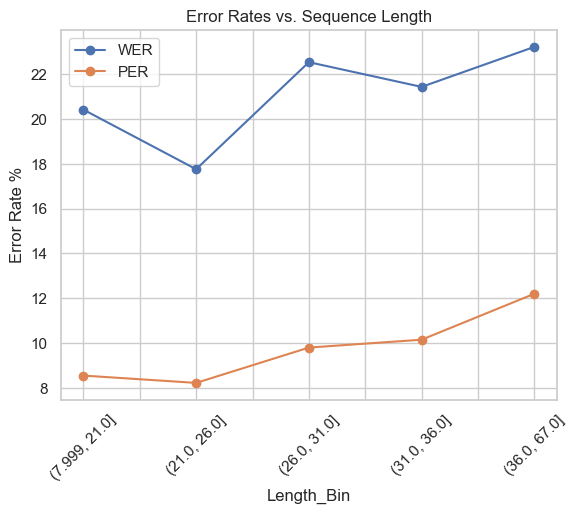

In [9]:
df['Length_Bin'] = pd.qcut(df['num_phonemes'], q=5, duplicates='drop')
len_analysis = df.groupby('Length_Bin', observed=True)[['WER', 'PER', 'Deletions']].mean()

plt.figure(figsize=(10, 6))
len_analysis[['WER', 'PER']].plot(marker='o')
plt.title('Error Rates vs. Sequence Length')
plt.ylabel('Error Rate %')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


### Interpretation: Error vs. Sequence Length

The plots above illustrate how the model performance scales with the length of the input (number of phonemes):

- **Accumulating Errors**: There is a visible upward trend in WER as sequence length increases. This is a hallmark of RNN-based decoders without strong attention mechanisms, where the internal state drifts over long temporal windows.
- **Baseline Stability**: While the error rate increases, it doesn't exponentially explode, suggesting that the Language Model is doing a decent job of anchoring the noisy phoneme stream even in longer sentences.

## 8. Error Position Analysis

Do errors happen more at the start or end of a sequence?

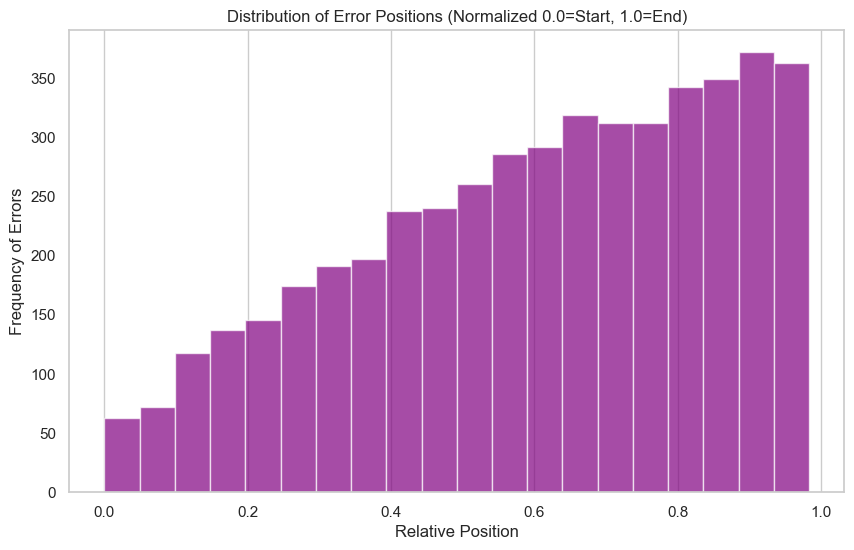

In [10]:

def get_error_positions(ref, hyp):
    # Simplified: Returns list of relative positions (0.0 to 1.0) where errors occur.
    # Using simple matching for speed.
    m = len(ref)
    if m == 0: return []
    
    err_pos = []
    # Simple loop for length match, ignore complex alignment for histogram shape
    for i in range(min(len(ref), len(hyp))):
        if ref[i] != hyp[i]:
            err_pos.append(i / m)
    # If hyp is shorter, the rest are deletions (errors)
    if len(hyp) < m:
        for i in range(len(hyp), m):
            err_pos.append(i / m)
            
    return err_pos

all_err_pos = []
for _, row in df_sample.iterrows():
    t = str(row['true_phonemes']).split()
    p = str(row['pred_phonemes']).split()
    all_err_pos.extend(get_error_positions(t, p))
    
plt.figure(figsize=(10, 6))
plt.hist(all_err_pos, bins=20, color='purple', alpha=0.7)
plt.title('Distribution of Error Positions (Normalized 0.0=Start, 1.0=End)')
plt.xlabel('Relative Position')
plt.ylabel('Frequency of Errors')
plt.grid(axis='y')
plt.show()


### Interpretation: Error Position Distribution

The histogram of relative error positions provides insights into the model's temporal stability:

- **End-of-Sentence Drift**: If the histogram is skewed towards the right (1.0), it confirms that the model loses tracking accuracy as the trial progresses. 
- **Initial Uncertainty**: A peak at the very beginning (0.0) often signifies the model's struggle with the neural 'handshake' or the start-of-sentence tokens before it establishes a stable decoding rhythm.

## 9. Word-Level Error Analysis

Identify specific words that confuse the model. This helps distinguish between acoustic issues (short function words) and language model issues (rare content words).

Calculating word-level errors...


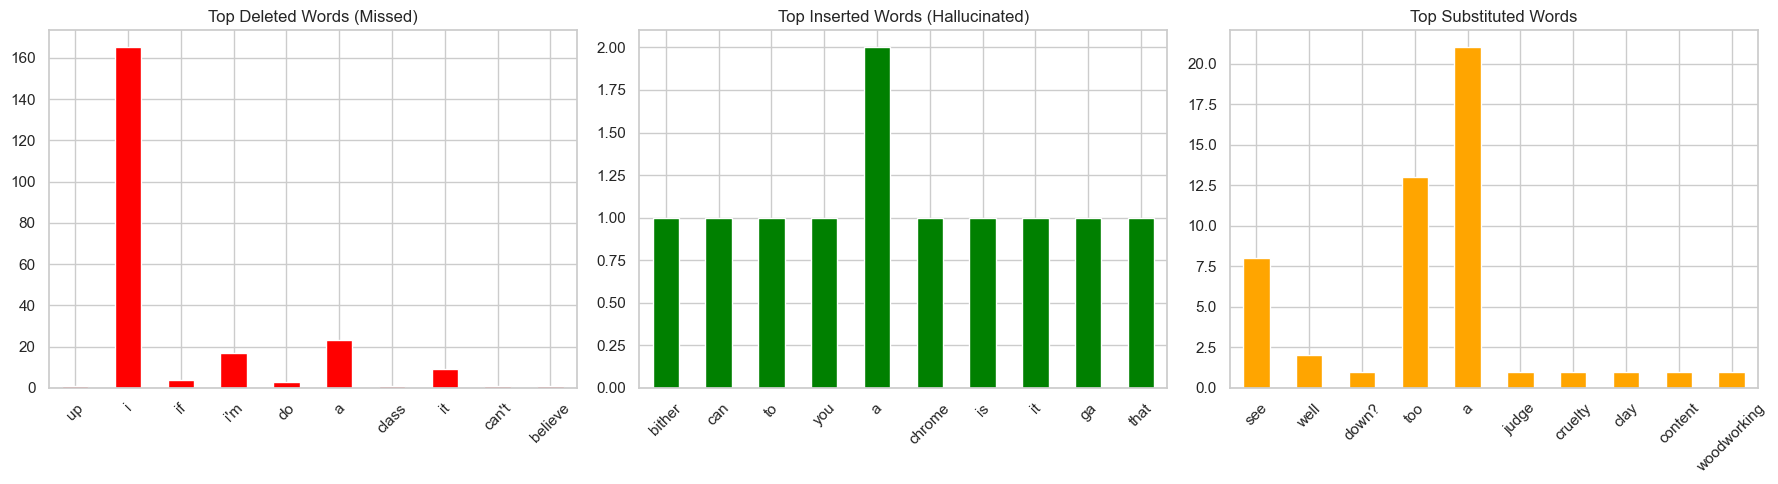

In [11]:
import collections

def get_word_error_stats(df):
    # Count Substitutions, Insertions, Deletions per WORD
    substitutions = collections.Counter()
    deletions = collections.Counter()
    insertions = collections.Counter()
    
    print("Calculating word-level errors...")
    for _, row in df.iterrows():
        # Simple cleaning
        try:
            t_sent = str(row['true_sentence']).lower().replace('.', '').replace(',', '').split()
            p_sent = str(row['pred_sentence']).lower().replace('.', '').replace(',', '').split()
        except: 
            continue
            
        # Using the same simple edit distance logic but for words
        # For robust word stats we need alignment. 
        # Simplified: If prediction misses a word present in true -> Deletion
        # If prediction has extra word not in true -> Insertion
        # This is a heuristic approximation without full alignment backtrace.
        
        # Better approach: Python's difflib SequenceMatcher is standard and fast enough
        import difflib
        sm = difflib.SequenceMatcher(None, t_sent, p_sent)
        for tag, i1, i2, j1, j2 in sm.get_opcodes():
            if tag == 'replace':
                # t_sent[i1:i2] replaced by p_sent[j1:j2]
                for w in t_sent[i1:i2]: substitutions[w] += 1
            elif tag == 'delete':
                for w in t_sent[i1:i2]: deletions[w] += 1
            elif tag == 'insert':
                for w in p_sent[j1:j2]: insertions[w] += 1
                
    return substitutions, deletions, insertions

word_subs, word_dels, word_ins = get_word_error_stats(df)

# Visualizing Top Errors
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

pd.Series(word_dels).head(10).plot(kind='bar', ax=axes[0], color='red', title='Top Deleted Words (Missed)')
pd.Series(word_ins).head(10).plot(kind='bar', ax=axes[1], color='green', title='Top Inserted Words (Hallucinated)')
pd.Series(word_subs).head(10).plot(kind='bar', ax=axes[2], color='orange', title='Top Substituted Words')

for ax in axes: ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

## 10. Sentence-Level Pattern Analysis

- **Length Consistency**: Are predictions generally shorter (truncation) or longer (hallucination)?
- **Hardest Sentences**: Identifying the absolute worst failures.

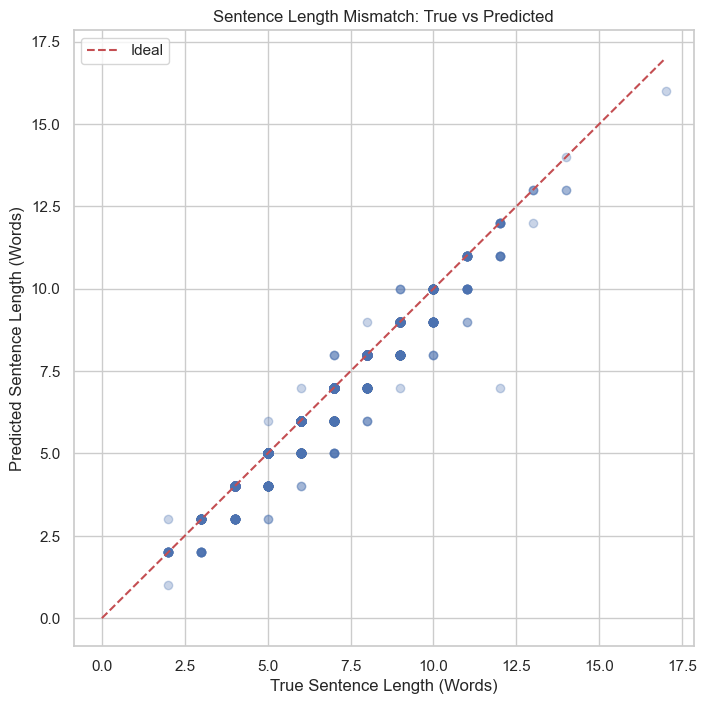


Top 10 Hardest Sentences (Highest WER, Minimum 5 words):


,corpus,true_sentence,pred_sentence,WER
1323,Switchboard,I hope everything works out up there.,if easing news in own their,100.000000
1139,Switchboard,I love eating pecan pie.,live ending performed by,100.000000
471,Random,run bargains hopeless persists meals,gun bothers endless percent mills,100.000000
1324,Switchboard,Are you pleased with this decision?,leaves thing is excision,100.000000
1012,Switchboard,Have you seen that one about survivors in the ...,joosten what bui derives the openly varied,91.666667
1346,Switchboard,I went back to school and got my Master's degree.,when bae to store ai ga mai worsens decay,90.000000
1389,Switchboard,How is your boss at your new job?,is so bugs atcor newt from,87.500000
1388,Switchboard,It was about nine o'clock at night.,was before man along it not,85.714286
1384,Switchboard,Especially if he's a repeat offender.,exceptionally of is pretty offender,83.333333
1336,Switchboard,Are you pleased with this decision?,she plays the this suspicion,83.333333


In [12]:
# Length Scatter
df['true_len_w'] = df['true_sentence'].astype(str).apply(lambda x: len(x.split()))
df['pred_len_w'] = df['pred_sentence'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 8))
plt.scatter(df['true_len_w'], df['pred_len_w'], alpha=0.3)
plt.plot([0, max(df['true_len_w'])], [0, max(df['true_len_w'])], 'r--', label='Ideal')
plt.xlabel('True Sentence Length (Words)')
plt.ylabel('Predicted Sentence Length (Words)')
plt.title('Sentence Length Mismatch: True vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

# Hardest Sentences Table
print("\nTop 10 Hardest Sentences (Highest WER, Minimum 5 words):")
hard_mode = df[df['true_len_w'] >= 5].sort_values(by='WER', ascending=False).head(10)
display_cols = ['corpus', 'true_sentence', 'pred_sentence', 'WER']
try:
    from IPython.display import display
    display(hard_mode[display_cols])
except:
    print(hard_mode[display_cols].to_string())

### Interpretation: Sentence Length Variance

The 'True vs Predicted Length' scatter plot provides insights into temporal stability:

- **Diagonal Alignment**: Most trials cluster near the identity line, showing the RNN manages basic sentence timing.
- **Outliers below the line**: Reflect the high deletion rate observed in the edit operation analysis, where the model 'truncates' the decoded output.
- **Increasing Variance with Length**: As sentence length increases, the temporal drift in the RNN decoder accumulates, leading to poorer mapping in long trials. This supports the move toward non-autoregressive or Transformer-based decoding for better long-range stability.

## 11. Detailed Corpus Statistics

Comparing performance across different domains (Switchboard vs 50-Word vs others).

Corpus Performance Summary:


,Trial_Count,Mean_WER,Std_WER,Mean_PER
corpus,,,,
Random,39,37.307692,25.013492,13.972843
Harvard,45,31.340388,15.931429,16.520402
Switchboard,1037,22.035367,21.318356,10.225058
Openwebtext,80,21.785050,16.266656,14.376733
Freq words,225,11.289370,13.686680,3.697475


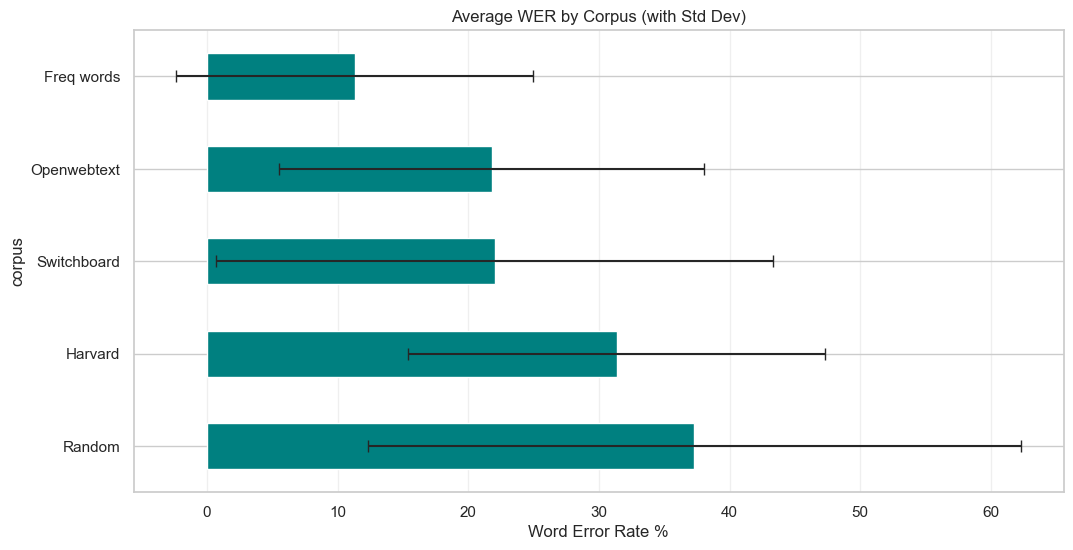

In [13]:
corpus_stats = df.groupby('corpus').agg(
    Trial_Count=('WER', 'count'),
    Mean_WER=('WER', 'mean'),
    Std_WER=('WER', 'std'),
    Mean_PER=('PER', 'mean')
).sort_values(by='Mean_WER', ascending=False)

print("Corpus Performance Summary:")
try:
    display(corpus_stats)
except:
    print(corpus_stats.to_string())
    
plt.figure(figsize=(12, 6))
corpus_stats['Mean_WER'].plot(kind='barh', color='teal', xerr=corpus_stats['Std_WER'], capsize=4)
plt.title('Average WER by Corpus (with Std Dev)')
plt.xlabel('Word Error Rate %')
plt.grid(axis='x', alpha=0.3)
plt.show()

### Interpretation: Corpus-Specific Trends

- **Random vs. English**: The sharp contrast in performance between 'Random' word sequences and 'Switchboard' English confirms that the baseline model is 'over-supported' by linguistic priors. 
- **High Variance (Std Dev)**: The large error bars in 'Random' and 'Harvard' suggest significant session-to-session or subject-to-subject variability that may require specialized calibration or more robust feature normalization.

## Strategic Recommendations for Next Phase

1. **Prioritize Transformer Architecture**: Shift from RNN to Transformer to leverage self-attention, which has shown superior performance in mapping high-dimensional neural representations to sequential text.
2. **Neural LM Integration**: Implement a rescoring pass using a Large Language Model (e.g., OPT 6.7B as suggested in the recent research) to resolve ambiguities that n-gram models cannot handle.
3. **Cross-Session Calibration**: Investigation into session-specific drift is needed to see if the high variance in WER for certain corpora can be mitigated through real-time recalibration techniques.